# PyIceberg 🐍 Tabular Custom Snowflake Mirroing Guide
Hey, welcome! 

This guide shows how you can mirror tables from your Tabular catalog into Snowflake.

Tabular offers warehouse-wide automated mirroring to Snowflake that works in most cases, but there are a few situations where you may want something different:
- you may want to mirror just a few of your tables
- you may want to mirror an iceberg table to multiple Snowflake locations
- maybe you want to mirror before an ETL job kicks off (like dbt) rather than mirroring constantly with every change to your iceberg table
- probably some other reasons, who knows 🤷

### Guide Overview:
Buckle up, because this one has a few steps. Broadly, this is what we'll do:
1. Setup Tabular (assuming you already have a warehouse there)
- Get a service credential
- take note of your warehouse's location in s3 as you'll need that
2. Setup Snowflake:
- create some assets / service account in snowflake
- take note of some generated values that snowflake will give you
3. Setup AWS:
- Snowflake needs a role and some s3 read access after step 2
4. Get down to business!
- we'll use pyiceberg to mirror our tables to snowflake using everything we set up above
- luckily steps 1-3 are all one time initial set up, so from here on out we're good to go.

### Python Dependencies:
- clone this repo (just do it, it takes 2 seconds)
- cd into this folder
- install packages: `poetry install`

See, that wasn't so bad.


## 1. Tabular Setup:
- head over to app.tabular.io and log in (or signup if you don't already have an account)
- go to connections > security > service account and hit the big + button to create a new service account credential
- assign your service account credential to a role that has the correct access for what you want to do (if you don't know, `EVERYONE` is a pretty safe default)
  - We will need full read on your cdc changelog tables
  - We will also need write to the location you want your mirror tables to end up in
- copy that credential!
- come back here and create a `.env` file in this directory (`guides/pyiceberg_cdc_automation/.env`). Edit it to look like below and make sure to SAVE IT.
```
TABULAR_CREDENTIAL=t-asdf:1234
```
⬆️ replace `t-asdf:1234` with the tabular credential you just created. 

Good job! Now we're ready to get down to business 💪

### Double check:
- Seriously, make sure you save that .env file. 
- if this is scary, you can ignore the `.env` file and just paste your credential in plaintext directly in this notebook -- but you should feel bad about your craftsmanship.


*One last note* -- you definitely don't have the same data I do. Make sure you use your own configs as required, but this should be a good starting point for you.

# Snowflake Setup
Now its time to set up some access in Snowflake. Here's what you'll need:
- a user account for this code to use to issue iceberg table create commands
- that user account needs to have a default role assigned with access to:
  - create tables in your desired database/schema 
  - use a data warehouse
  - use the catalog and external volume you'll create below

That's it! Probably!

Here's a sample Snowflake script to get this cooking. The emojis point out places where you need to add values yourself:
```sql
// -----------------------------------------------
// create security admin assets
// -----------------------------------------------
use role securityadmin;
create role pyiceberg_mirroring_service_role;
grant role pyiceberg_mirroring_service_role to role sysadmin; 

// you can create these if they do not exist. This guide is just a starting point
grant usage on database my_target_database🪐 to role pyiceberg_mirroring_service_role;
grant ownership on schema my_target_database🪐.my_mirroring_schema🧊 to role pyiceberg_mirroring_service_role copy grants;
grant usage on warehouse some_cool_warehouse 🪐 to role pyiceberg_mirroring_service_role; // an xs is plenty here. Just doing some metadata ops 💪

create user pyiceberg_mirroring_service_user 
  password = '😎',
  default_role = pyiceberg_mirroring_service_role,
  default_warehouse = some_cool_warehouse 🪐; 
  
grant role pyiceberg_mirroring_service_role to user pyiceberg_mirroring_service_user;
// -----------------------------------------------


// -----------------------------------------------
// create account admin assets 
// -----------------------------------------------
use role accountadmin;
create external volume tabular_my_cool_warehouse_volume // I like to name these same as my warehouse, so tabular_enterprise_data_warehouse_volume for example 
  allow_writes=false
  storage_locations = ((
      name = 🌞'tabular_my_cool_warehouse_volume'
      storage_provider = 'S3'
      storage_aws_role_arn = 🌞'arn:aws:iam::account_id:role/snowflake-tabular-my-cool-warehouse-volume' // call this what you like. We will create the role in your aws account after this
      storage_base_url = 🌞's3://my-s3-bucket-where-tabular-puts-my-warehouse/my-warehouse-uuid-probably/' // this is the s3 location of your tabular warehouse.
  ));

create catalog integration tabular_my_cool_warehouse_catalog
  catalog_source = object_store
  table_format = iceberg
  enabled = true
  comment = 'Tabular.io Catalog Integration';
  
// let the service role use these nifty new iceberg objects
grant usage on integration tabular_my_cool_warehouse_catalog to role pyiceberg_mirroring_service_role;
grant usage on volume tabular_my_cool_warehouse_volume to role pyiceberg_mirroring_service_role;
// -----------------------------------------------


// -----------------------------------------------
// Get details from newly-created integration 
// objects. 
// -----------------------------------------------
use role pyiceberg_mirroring_service_role;
use warehouse some_cool_warehouse 🪐;
describe external tabular_my_cool_warehouse_volume;


// this query will give you 2 values you will need to create the snowflake access role in AWS
select 
  parse_json("property_value"::string):"STORAGE_AWS_IAM_USER_ARN"::string as storage_aws_iam_user_arn,
  parse_json("property_value"::string):"STORAGE_AWS_EXTERNAL_ID"::string as storage_aws_external_id,
  'https://' || lower(current_account()) || '.snowflakecomputing.com' as snowflake_account_url
  
from table(result_scan(last_query_id()))

where "parent_property"='STORAGE_LOCATIONS' and "property"='STORAGE_LOCATION_1';

```

🚧 Quick check!
- make sure to grab those two important fields from Snowflake -- or just keep them handy for the AWS step
- I attached a screenshot of my results. You should see different values but the same kinda thing after running the final SQL statement in the script above.
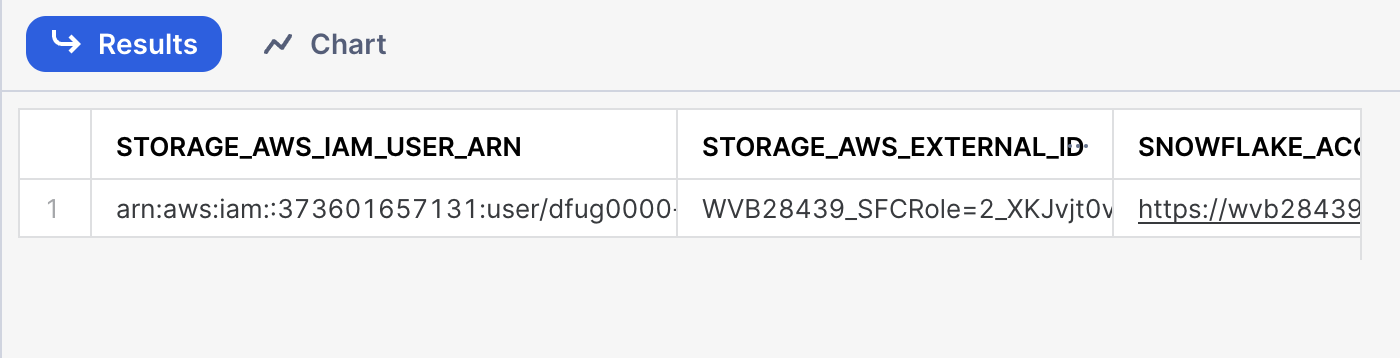

## 3. AWS Setup
No one panic, but it's time to log in to AWS and go to IAM and create a new policy + role 💪

### Create Policy
- let's start with the policy. We need to build a read only policy for your S3 location that holds the Tabular Iceberg warehouse you want to mirror
- check out the screenshot below for the one I have, then I'll share a JSON policy you can use with your own s3 locations


In [4]:
# Establish our connection with Tabular 💪

from dotenv import load_dotenv
import os

from pyiceberg.catalog import load_catalog
from pyiceberg.exceptions import TableAlreadyExistsError

# You'll need a tabular credential. Member credential or service account will work fine
load_dotenv('./.env')

TABULAR_CREDENTIAL       = os.environ['TABULAR_CREDENTIAL']
TABULAR_TARGET_WAREHOUSE = 'enterprise_data_warehouse' # replace this with your tabular warehouse name
TABULAR_CATALOG_URI      = 'https://api.tabular.io/ws' # unless you're a single tenant user, you don't need to change this

catalog_properties = {
    'uri':        TABULAR_CATALOG_URI,
    'credential': TABULAR_CREDENTIAL,
    'warehouse':  TABULAR_TARGET_WAREHOUSE
}
catalog = load_catalog(**catalog_properties)

In [ ]:
# fetch the table and get its metadata location. This is what snowflake uses to refresh it's mirror'd table object.
table = catalog.load_table("batch_raw.serverless_weather_raw")
metadata_location = table.metadata_location
print(f"metadata location: {metadata_location}")

metadata location: s3://randy-pitcher-workspace--aws--us-west-2/097a7cbb-5095-40ed-bf80-dabafbacd09e/0af68f25-2fbf-4888-8612-b8c224c425a8/metadata/59859-ee066699-4690-4886-809c-cd9dffb2cd5e.gz.metadata.json


In [6]:
# set some configs for finding our changelog tables 💪
changelog_db = 'kafka_connect_raw' # this should already exist
changelog_table_postfix = '_changelog' # set this to '' or None if you don't use one of these. But you should really consider it.

# set some configs for placing the mirror tables 💪
mirror_db = 'cdc_mirrors' # this doesn't have to exist. If it does, awesome -- if not we'll create it
mirror_table_postfix = '_mirror' # set this to '' or None if you don't want one of these.
mirror_table_should_expand_key_col_struct = True # set to false if your key-column is a scalar

# CDC configs for processing the mirror tables 💪
cdc_properties = { # https://docs.tabular.io/change-data-capture for more details on this ⬇️
    'cdc.type':       'DMS', # don't change this unless you know what you're doing, even if you're not using DMS
    'etl.job-type':   'cdc', # don't change this unless you know what you're doing. Even then, maybe don't change this as of 2024-04-01
    'etl.target-lag': '0',  # 15 minutes
    'cdc.key-column-default': '_cdc.key', # can be the ID of the table as well. This _cdc.key works for any debezium changelog data using the kafka connect iceberg sink with tabular's dbz transform
    'cdc.ts-column':  '_cdc.ts',  # the timestamp column of when the change happened
}

In [7]:
# get changelog tables to build mirrors for 💪
changelog_tables = []
for _, tablename in catalog.list_tables(changelog_db):
    if not changelog_table_postfix or tablename.endswith(changelog_table_postfix):
        changelog_tables.append(catalog.load_table(f"{changelog_db}.{tablename}"))
        print(f"Found changelog table: '{changelog_tables[-1].identifier[-1]}'")

Found changelog table: 'dbz_pg_reactions_changelog'
Found changelog table: 'dbz_zodiac_changelog'


In [8]:
# Build mirrors 💪

# init mirror db then process a mirror for each changelog, skipping those that may already exist
try:
    catalog.create_namespace(mirror_db)
    print(f"Succesfully created mirror namespace '{mirror_db}'. 🪐\n")
except:
    print(f"namespace '{mirror_db}' already exists, moving on 💪\n") # lazy, but assuming an error here is because it already exists


# process the mirror tables
for changelog_table in changelog_tables:
    mirror_table_name = mirror_db + '.' + changelog_table.identifier[-1].replace(changelog_table_postfix, mirror_table_postfix)
    try:
        # create the table with the same schema as the changelog
        mirror_table = catalog.create_table(
            identifier=mirror_table_name,
            schema=changelog_table.schema()
        )

        # get the unique key(s) for this change log:
        if mirror_table_should_expand_key_col_struct:
            # get to choppin up that _cdc.key struct
            cdc_key_columns = []
            for field in changelog_table.schema().find_field(cdc_properties['cdc.key-column-default']).field_type.fields:
                cdc_key_columns.append(cdc_properties['cdc.key-column-default'] + '.' + field.name)

            cdc_properties['cdc.key-column'] = ','.join(cdc_key_columns)
        else:
            cdc_properties['cdc.key-column'] = cdc_properties['cdc.key-column-default']

        # set the cdc table props for this new mirror
        with mirror_table.transaction() as transaction:
            transaction.set_properties(**cdc_properties)

        # update the changelog table so it triggers CDC processing against this mirror
        changelog_cdc_property = { # https://docs.tabular.io/change-data-capture for more details
            'dependent-tables': mirror_table_name
        }
        with changelog_table.transaction() as transaction:
            transaction.set_properties(**changelog_cdc_property)

        print(f"\tSuccesfully created and configured cdc mirror '{mirror_table_name}'🪐")
        
        
    except TableAlreadyExistsError:
        print(f"Mirror table already exists for table '{mirror_table_name}'. Taking no action here and moving on to the next table ⚡")

print('\nYour CDC changes will begin to flow AFTER new change records hit your changelog tables')

Succesfully created mirror namespace 'cdc_mirrors'. 🪐

	Succesfully created and configured cdc mirror 'cdc_mirrors.dbz_pg_reactions_mirror'🪐
	Succesfully created and configured cdc mirror 'cdc_mirrors.dbz_zodiac_mirror'🪐

Your CDC changes will begin to flow AFTER new change records hit your changelog tables
